# Item Based CF and Book Recs Demo

This notebook gives functionalities showing top similar books based on IBCF (Item-based Collaborative Filtering).

In [3]:
import os
import pickle
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.model_selection import KFold, train_test_split
from sklearn.neighbors import NearestNeighbors

In [4]:
def make_mean_0(X: sp.sparse.csc_matrix) -> None:
    """
    make columns of a csc_matrix have zero mean
    (this function mutates the underlying data)
    """
    X.data -= get_true_mean(X)

def get_true_mean(X: sp.sparse.csc_matrix) -> None:
    """
    compute mean of each column (over nonzero indices!)
    this won't mutate the underlying X
    a general helper function
    """
    indexer = X.tocoo().col
    v = np.array(X.sum(axis=0)).flatten()
    c = np.array(X.minimum(1).sum(axis=0)).flatten()
    return v[indexer] / np.maximum(c[indexer], 0.5)

In [5]:
def get_top_neigh_dist_ind(
    ratings_train_csc_modified,
    ratings_test_csc_modified,
    n_neighbors=5
):
    knn = NearestNeighbors(metric="cosine")
    knn.fit(ratings_train_csc_modified.transpose())
    neigh_dist, neigh_ind = knn.kneighbors(
        X=ratings_test_csc_modified.transpose(),
        n_neighbors=n_neighbors
    )
    return 1 - neigh_dist, neigh_ind

In [6]:
def update_numer_denom(
    numer_test_csc_ratings,
    denom_test_csc_ratings,
    ratings_test_csc,
    ratings_train_csc,
    ratings_train_mean,
    n_items,
    n_users_test,
    pos # position of which neighbor to update
):
    """
    this function mutates the input csc matrices
    """
    start_ind = 0
    for i in np.arange(n_users_test):
        denom_col = np.zeros(n_items)
        numer_col = np.zeros(n_items)
        baseline_items = ratings_test_csc.indices[
            ratings_test_csc.indptr[i]: ratings_test_csc.indptr[i + 1]
        ]
        n_baseline_items = len(baseline_items)
        end_ind = start_ind + n_baseline_items
        j = neigh_ind[i, pos]
        sim_score = sim_scores[i, pos]
        r_v = ratings_train_csc[:, j]\
                .toarray().flatten()[baseline_items]
        mu_v = ratings_train_mean[j]
        w = sim_score * np.minimum(1, r_v)
        numer_test_csc_ratings.data[start_ind: end_ind] += w * (r_v - mu_v)
        denom_test_csc_ratings.data[start_ind: end_ind] += w
        start_ind = end_ind

In [7]:
def update_prediction(
    ratings_test_csc_predicted,
    ratings_test_mean,
    numer_test_csc_ratings,
    denom_test_csc_ratings
):
    ratings_test_csc_predicted.data =\
        ratings_test_mean[ratings_test_csc_predicted.tocoo().col] +\
        numer_test_csc_ratings.data /\
        np.maximum(
            denom_test_csc_ratings.data,
            10 ** (-30)
        )

In [8]:
def eval_error(ratings_diffs: np.ndarray, sense:str="RMSE"):
    """
    function for evaluating MSE, RMSE, MAE, MAPE of a ratings_diffs array
    """
    if sense not in {"MSE", "RMSE", "MAE", "MAPE"}:
        raise NotImplementedError
    elif sense in {"RMSE", "MAE"}:
        p = {"RMSE": 2, "MAE": 1}[sense]
        return np.linalg.norm(ratings_diffs, p) / ratings_diffs.shape[0] ** (1 / p)
    elif sense == "MSE":
        return ((ratings_diffs)**2).sum()/ratings_diffs.shape[0]
    else:
        return (np.abs(ratings_diffs)/np.abs(ratings_test_csc.data)).sum()/ratings_diffs.shape[0]

## Item-Based Collaborative Filtering with Generated Top 200 Books (Scores + ID)

In [18]:
%%time
results = []
n_neighbors = 201

# transform to csc matrix
csv_dir = "/home/zebalgebra/School/DVA/The-Last-Book-Bender/Data/Raw/"
ratings_all_df = pd.read_csv(
    os.path.join(csv_dir, "ratings.csv")
)
# since we do item-based, book_id and user_id are switched (books are columns)
ratings_all_csc = sp.sparse.csc_matrix(
    (
        ratings_all_df["rating"],
        (
            ratings_all_df["user_id"],
            ratings_all_df["book_id"]
        )
    )
)

# get top recs for books
user_ids = np.arange(10000 + 1)

ratings_train_csc = ratings_all_csc.copy()
ratings_test_csc = ratings_all_csc.copy()
ratings_train_mean = get_true_mean(ratings_train_csc)
ratings_test_mean = get_true_mean(ratings_test_csc)
n_items = ratings_test_csc.shape[0]
n_users_test = 10001

# modify train, test csc matrix
ratings_train_csc_modified = ratings_train_csc.copy().astype(np.float64)
ratings_test_csc_modified = ratings_test_csc.copy().astype(np.float64)
make_mean_0(ratings_train_csc_modified)
make_mean_0(ratings_test_csc_modified)
# get top neighbors and scores
sim_scores, neigh_ind = get_top_neigh_dist_ind(
    ratings_train_csc_modified,
    ratings_test_csc_modified,
    n_neighbors=n_neighbors
)

with open(f'book-top-200.pkl', 'wb') as f:
    pickle.dump([sim_scores, neigh_ind], f)

CPU times: user 7.22 s, sys: 754 ms, total: 7.98 s
Wall time: 8.01 s


In [19]:
print(sim_scores)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [1.         0.41177088 0.30856051 ... 0.03346572 0.03344025 0.03343182]
 [1.         0.45028636 0.41389503 ... 0.03491968 0.03485617 0.03478531]
 ...
 [1.         0.5199571  0.48985644 ... 0.01554969 0.0155148  0.01551345]
 [1.         0.05358143 0.0497866  ... 0.0136174  0.01361239 0.01356286]
 [1.         0.17128314 0.14358053 ... 0.01995482 0.01995106 0.01990338]]


The similarity scores and top 200 similar books for each books are given stored in `book-top-200.pkl`.

In [34]:
sim_df = pd.DataFrame(
    np.hstack(
        (
            np.arange(1, 10001).reshape((10000, 1)),
            sim_scores[1:, 1:]
        )
    )
)
sim_df.columns = ["book_id", *[f"score of rank {i} similar book" for i in range(1, 201)]]
sim_df["book_id"] = sim_df["book_id"].astype("int")
sim_df

,book_id,score of rank 1 similar book,score of rank 2 similar book,score of rank 3 similar book,score of rank 4 similar book,score of rank 5 similar book,score of rank 6 similar book,score of rank 7 similar book,score of rank 8 similar book,score of rank 9 similar book,...,score of rank 191 similar book,score of rank 192 similar book,score of rank 193 similar book,score of rank 194 similar book,score of rank 195 similar book,score of rank 196 similar book,score of rank 197 similar book,score of rank 198 similar book,score of rank 199 similar book,score of rank 200 similar book
0,1,0.411771,0.308561,0.186353,0.162507,0.157140,0.116227,0.114403,0.113010,0.111709,...,0.034024,0.033875,0.033841,0.033821,0.033560,0.033542,0.033479,0.033466,0.033440,0.033432
1,2,0.450286,0.413895,0.376855,0.328172,0.327037,0.297515,0.157140,0.132038,0.126953,...,0.035368,0.035219,0.035197,0.035189,0.035078,0.034924,0.034922,0.034920,0.034856,0.034785
2,3,0.448119,0.447816,0.400942,0.186353,0.180907,0.168054,0.152496,0.131615,0.130190,...,0.037953,0.037828,0.037706,0.037694,0.037677,0.037676,0.037633,0.037551,0.037289,0.037256
3,4,0.185171,0.170706,0.155655,0.152765,0.147965,0.141324,0.128294,0.123147,0.119817,...,0.033895,0.033795,0.033767,0.033738,0.033617,0.033602,0.033513,0.033502,0.033425,0.033420
4,5,0.218034,0.170706,0.146669,0.142154,0.137420,0.133756,0.126081,0.107386,0.103970,...,0.035466,0.035413,0.035175,0.035144,0.035069,0.035015,0.034874,0.034865,0.034658,0.034602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,0.397639,0.225291,0.188271,0.187703,0.167301,0.164037,0.163094,0.161047,0.148262,...,0.023694,0.023630,0.023535,0.023526,0.023482,0.023421,0.023409,0.023176,0.022899,0.022857
9996,9997,0.263339,0.172648,0.073245,0.064155,0.062760,0.060178,0.052366,0.047740,0.047481,...,0.012270,0.012233,0.012231,0.012219,0.012201,0.012136,0.012131,0.012091,0.012073,0.011993
9997,9998,0.519957,0.489856,0.192628,0.079375,0.063140,0.057054,0.054121,0.050907,0.045580,...,0.015779,0.015767,0.015745,0.015720,0.015711,0.015638,0.015625,0.015550,0.015515,0.015513
9998,9999,0.053581,0.049787,0.049492,0.046982,0.045087,0.042286,0.040663,0.040483,0.040085,...,0.013729,0.013705,0.013695,0.013688,0.013654,0.013652,0.013645,0.013617,0.013612,0.013563


In [31]:
rec_df = pd.DataFrame(
    np.hstack(
        (
            np.arange(1, 10001).reshape((10000, 1)),
            neigh_ind[1:, 1:]
        )
    )
)
rec_df.columns = ["book_id", *[f"id of rank {i} similar book" for i in range(1, 201)]]
rec_df

,book_id,id of rank 1 similar book,id of rank 2 similar book,id of rank 3 similar book,id of rank 4 similar book,id of rank 5 similar book,id of rank 6 similar book,id of rank 7 similar book,id of rank 8 similar book,id of rank 9 similar book,...,id of rank 191 similar book,id of rank 192 similar book,id of rank 193 similar book,id of rank 194 similar book,id of rank 195 similar book,id of rank 196 similar book,id of rank 197 similar book,id of rank 198 similar book,id of rank 199 similar book,id of rank 200 similar book
0,1,17,20,3,12,2,9,27,25,23,...,368,389,370,112,992,519,329,417,4603,526
1,2,23,18,24,21,27,25,1,26,37,...,188,56,627,339,1196,83,358,967,58,451
2,3,49,52,56,1,34,73,44,53,51,...,1291,1437,571,1861,85,118,222,541,3083,84
3,4,32,5,15,8,28,58,29,10,14,...,341,227,335,222,741,196,1094,369,740,601
4,5,8,4,28,32,14,29,13,63,58,...,426,413,1,205,317,81,741,646,245,659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,6812,7319,4921,3463,7101,3105,7939,2998,2971,...,1769,4446,891,7818,1594,8058,5722,2706,5904,7596
9996,9997,9004,7264,9666,6131,8034,2950,9751,6298,7245,...,969,501,8433,4515,3529,172,1710,236,7869,1926
9997,9998,8687,7501,3109,7855,5764,7351,9019,9789,9655,...,4464,6982,8358,5665,628,4727,1089,3547,135,687
9998,9999,2742,9542,8073,4956,9375,4309,5761,7518,4389,...,92,30,2132,122,7615,1168,5129,2444,4959,5912


## Looking at Book Infos

Now we look at book infos by joining `books.csv`

In [36]:
# transform to csc matrix
csv_dir = "/home/zebalgebra/School/DVA/The-Last-Book-Bender/Data/Raw/"
books_all_df = pd.read_csv(
    os.path.join(csv_dir, "books_enriched.csv")
)

Say we sample 5 books, and look at the infos.

In [64]:
sample_ids = [2, 6, 9, 42, 420]

In [40]:
books_all_df.columns

Index(['Unnamed: 0', 'index', 'authors', 'average_rating', 'best_book_id',
       'book_id', 'books_count', 'description', 'genres', 'goodreads_book_id',
       'image_url', 'isbn', 'isbn13', 'language_code',
       'original_publication_year', 'original_title', 'pages', 'publishDate',
       'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5',
       'ratings_count', 'small_image_url', 'title', 'work_id',
       'work_ratings_count', 'work_text_reviews_count', 'authors_2'],
      dtype='object')

In [63]:
from IPython.display import Image
from IPython.core.display import HTML
from pprint import pprint
def vis_book_by_id(books_all_df, book_id, greeting_str):
    # shows info of entered book
    book_info = books_all_df.iloc[book_id - 1, :]
    print(greeting_str)
    display(Image(book_info["image_url"]))
    pprint(book_info.to_dict())
def vis_recs(books_all_df, base_book_id, sim_df, rec_df, num_recs):
    # shows info of entered book
    vis_book_by_id(
        books_all_df,
        base_book_id,
        """
        💫 Your entered book ! 😉
        """
    )
    rec_book_ids = rec_df.iloc[base_book_id - 1, 1:num_recs + 1].values
    rec_book_sims = sim_df.iloc[base_book_id - 1, 1:num_recs + 1].values
    for rank, (rec_book_id, rec_book_sim) in enumerate(
        zip(rec_book_ids, rec_book_sims)
    ):
        vis_book_by_id(
            books_all_df,
            rec_book_id,
            f"""
            💫 Rank {rank + 1} similar book of your entered book ! 😱
                (score: {rec_book_sim}, id: {rec_book_id})
            """
        )


        💫 Your entered book ! 😉
        


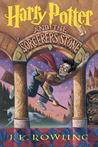

{'Unnamed: 0': 1,
 'authors': "['J.K. Rowling', 'Mary GrandPré']",
 'authors_2': "['J.K. Rowling', 'Mary GrandPré']",
 'average_rating': 4.44,
 'best_book_id': 3,
 'book_id': 2,
 'books_count': 491,
 'description': "Harry Potter's life is miserable. His parents are dead and "
                "he's stuck with his heartless relatives, who force him to "
                'live in a tiny closet under the stairs. But his fortune '
                'changes when he receives a letter that tells him the truth '
                "about himself: he's a wizard. A mysterious visitor rescues "
                'him from his relatives and takes him to his new home, '
                'Hogwarts School of Witchcraft and Wizardry.After a lifetime '
                'of bottling up his magical powers, Harry finally feels like a '
                'normal kid. But even within the Wizarding community, he is '
                'special. He is the boy who lived: the only person to have '
                'ever survi

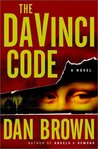

{'Unnamed: 0': 22,
 'authors': "['Dan Brown']",
 'authors_2': "['Dan Brown']",
 'average_rating': 3.79,
 'best_book_id': 968,
 'book_id': 26,
 'books_count': 350,
 'description': 'ISBN 9780307277671 moved to this edition.While in Paris, '
                'Harvard symbologist Robert Langdon is awakened by a phone '
                'call in the dead of the night. The elderly curator of the '
                'Louvre has been murdered inside the museum, his body covered '
                'in baffling symbols. As Langdon and gifted French '
                'cryptologist Sophie Neveu sort through the bizarre riddles, '
                'they are stunned to discover a trail of clues hidden in the '
                'works of Leonardo da Vinci—clues visible for all to see and '
                'yet ingeniously disguised by the painter.Even more startling, '
                'the late curator was involved in the Priory of Sion—a secret '
                'society whose members included Sir Isaac Ne

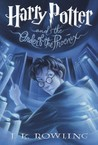

{'Unnamed: 0': 17,
 'authors': "['J.K. Rowling', 'Mary GrandPré']",
 'authors_2': "['J.K. Rowling', 'Mary GrandPré']",
 'average_rating': 4.46,
 'best_book_id': 2,
 'book_id': 21,
 'books_count': 307,
 'description': 'There is a door at the end of a silent corridor. And it’s '
                'haunting Harry Pottter’s dreams. Why else would he be waking '
                'in the middle of the night, screaming in terror?Harry has a '
                'lot on his mind for this, his fifth year at Hogwarts: a '
                'Defense Against the Dark Arts teacher with a personality like '
                'poisoned honey; a big surprise on the Gryffindor Quidditch '
                'team; and the looming terror of the Ordinary Wizarding Level '
                'exams. But all these things pale next to the growing threat '
                'of He-Who-Must-Not-Be-Named - a threat that neither the '
                'magical government nor the authorities at Hogwarts can '
                'stop

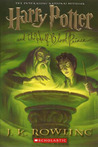

{'Unnamed: 0': 23,
 'authors': "['J.K. Rowling', 'Mary GrandPré']",
 'authors_2': "['J.K. Rowling', 'Mary GrandPré']",
 'average_rating': 4.54,
 'best_book_id': 1,
 'book_id': 27,
 'books_count': 275,
 'description': 'The war against Voldemort is not going well; even Muggle '
                'governments are noticing. Ron scans the obituary pages of the '
                'Daily Prophet, looking for familiar names. Dumbledore is '
                'absent from Hogwarts for long stretches of time, and the '
                'Order of the Phoenix has already suffered losses.And yet . . '
                '.As in all wars, life goes on. The Weasley twins expand their '
                'business. Sixth-year students learn to Apparate - and lose a '
                'few eyebrows in the process. Teenagers flirt and fight and '
                'fall in love. Classes are never straightforward, through '
                'Harry receives some extraordinary help from the mysterious '
                "

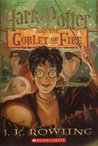

{'Unnamed: 0': 20,
 'authors': "['J.K. Rowling', 'Mary GrandPré']",
 'authors_2': "['J.K. Rowling', 'Mary GrandPré']",
 'average_rating': 4.53,
 'best_book_id': 6,
 'book_id': 24,
 'books_count': 332,
 'description': 'Harry Potter is midway through his training as a wizard and '
                'his coming of age. Harry wants to get away from the '
                'pernicious Dursleys and go to the International Quidditch Cup '
                'with Hermione, Ron, and the Weasleys. He wants to dream about '
                'Cho Chang, his crush (and maybe do more than dream). He wants '
                "to find out about the mysterious event that's supposed to "
                'take place at Hogwarts this year, an event involving two '
                "other rival schools of magic, and a competition that hasn't "
                'happened for hundreds of years. He wants to be a normal, '
                'fourteen-year-old wizard. But unfortunately for Harry Potter, '
                "

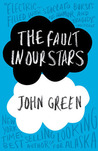

{'Unnamed: 0': 5,
 'authors': "['John Green']",
 'authors_2': "['John Green']",
 'average_rating': 4.26,
 'best_book_id': 11870085,
 'book_id': 6,
 'books_count': 226,
 'description': 'Despite the tumor-shrinking medical miracle that has bought '
                'her a few years, Hazel has never been anything but terminal, '
                'her final chapter inscribed upon diagnosis. But when a '
                'gorgeous plot twist named Augustus Waters suddenly appears at '
                "Cancer Kid Support Group, Hazel's story is about to be "
                'completely rewritten.Insightful, bold, irreverent, and raw, '
                "The Fault in Our Stars is award-winning author John Green's "
                'most ambitious and heartbreaking work yet, brilliantly '
                'exploring the funny, thrilling, and tragic business of being '
                'alive and in love.',
 'genres': "['young-adult', 'romance', 'fiction', 'contemporary']",
 'goodreads_book_id': 1187

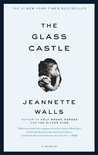

{'Unnamed: 0': 73,
 'authors': "['Jeannette Walls']",
 'authors_2': "['Jeannette Walls']",
 'average_rating': 4.24,
 'best_book_id': 7445,
 'book_id': 81,
 'books_count': 92,
 'description': 'A tender, moving tale of unconditional love in a family that, '
                'despite its profound flaws, gave the author the fiery '
                'determination to carve out a successful life on her own '
                'terms.Jeannette Walls grew up with parents whose ideals and '
                'stubborn nonconformity were both their curse and their '
                'salvation. Rex and Rose Mary Walls had four children. In the '
                'beginning, they lived like nomads, moving among Southwest '
                'desert towns, camping in the mountains. Rex was a '
                'charismatic, brilliant man who, when sober, captured his '
                "children's imagination, teaching them physics, geology, and "
                'above all, how to embrace life fearlessly. Ro

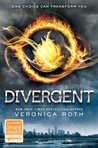

{'Unnamed: 0': 11,
 'authors': "['Veronica Roth']",
 'authors_2': "['Veronica Roth']",
 'average_rating': 4.24,
 'best_book_id': 13335037,
 'book_id': 12,
 'books_count': 210,
 'description': "In Beatrice Prior's dystopian Chicago world, society is "
                'divided into five factions, each dedicated to the cultivation '
                'of a particular virtue—Candor (the honest), Abnegation (the '
                'selfless), Dauntless (the brave), Amity (the peaceful), and '
                'Erudite (the intelligent). On an appointed day of every year, '
                'all sixteen-year-olds must select the faction to which they '
                'will devote the rest of their lives. For Beatrice, the '
                'decision is between staying with her family and being who she '
                "really is—she can't have both. So she makes a choice that "
                'surprises everyone, including herself.During the highly '
                'competitive initiation tha

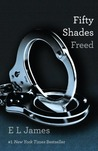

{'Unnamed: 0': 87,
 'authors': "['E.L. James']",
 'authors_2': "['E.L. James']",
 'average_rating': 3.88,
 'best_book_id': 13536860,
 'book_id': 96,
 'books_count': 133,
 'description': 'When unworldly student Anastasia Steele first encountered the '
                'driven and dazzling young entrepreneur Christian Grey it '
                'sparked a sensual affair that changed both of their lives '
                'irrevocably. Shocked, intrigued, and, ultimately, repelled by '
                'Christian’s singular erotic tastes, Ana demands a deeper '
                'commitment. Determined to keep her, Christian agrees.Now, Ana '
                'and Christian have it all—love, passion, intimacy, wealth, '
                'and a world of possibilities for their future.\xa0But Ana '
                'knows that loving her Fifty Shades will not be easy, and that '
                'being together will pose challenges that neither of them '
                'would anticipate.\xa0Ana must

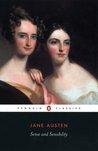

{'Unnamed: 0': 68,
 'authors': "['Jane Austen', 'Tony Tanner', 'Ros Ballaster']",
 'authors_2': "['Jane Austen', 'Tony Tanner', 'Ros Ballaster']",
 'average_rating': 4.06,
 'best_book_id': 14935,
 'book_id': 76,
 'books_count': 1969,
 'description': "Alternate cover edition of ISBN 9780141439662'The more I know "
                'of the world, the more am I convinced that I shall never see '
                "a man whom I can really love. I require so much!'Marianne "
                'Dashwood wears her heart on her sleeve, and when she falls in '
                'love with the dashing but unsuitable John Willoughby she '
                "ignores her sister Elinor's warning that her impulsive "
                'behaviour leaves her open to gossip and innuendo. Meanwhile '
                'Elinor, always sensitive to social convention, is struggling '
                'to conceal her own romantic disappointment, even from those '
                'closest to her. Through their parallel exp

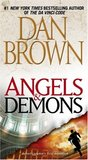

{'Unnamed: 0': 8,
 'authors': "['Dan Brown']",
 'authors_2': "['Dan Brown']",
 'average_rating': 3.85,
 'best_book_id': 960,
 'book_id': 9,
 'books_count': 311,
 'description': 'World-renowned Harvard symbologist Robert Langdon is summoned '
                'to a Swiss research facility to analyze a cryptic symbol '
                'seared into the chest of a murdered physicist. What he '
                'discovers is unimaginable: a deadly vendetta against the '
                'Catholic Church by a centuries-old underground organization '
                '-- the Illuminati. In a desperate race to save the Vatican '
                'from a powerful time bomb, Langdon joins forces in Rome with '
                'the beautiful and mysterious scientist Vittoria Vetra. '
                'Together they embark on a frantic hunt through sealed crypts, '
                'dangerous catacombs, and deserted cathedrals, and into the '
                'depths of the most secretive vault on earth..

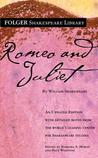

{'Unnamed: 0': 25,
 'authors': "['William Shakespeare', 'Robert           Jackson']",
 'authors_2': "['William Shakespeare', 'Robert           Jackson']",
 'average_rating': 3.73,
 'best_book_id': 18135,
 'book_id': 29,
 'books_count': 1937,
 'description': 'In Romeo and Juliet, Shakespeare creates a violent world, in '
                'which two young people fall in love. It is not simply that '
                'their families disapprove; the Montagues and the Capulets are '
                'engaged in a blood feud.In this death-filled setting, the '
                'movement from love at first sight to the lovers’ final union '
                'in death seems almost inevitable. And yet, this play set in '
                'an extraordinary world has become the quintessential story of '
                'young love. In part because of its exquisite language, it is '
                'easy to respond as if it were about all young lovers.',
 'genres': "['classics', 'fiction', 'romance', 'p

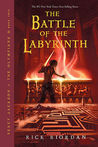

{'Unnamed: 0': 144,
 'authors': "['Rick Riordan']",
 'authors_2': "['Rick Riordan']",
 'average_rating': 4.39,
 'best_book_id': 2120932,
 'book_id': 159,
 'books_count': 92,
 'description': "Percy Jackson isn't expecting freshman orientation to be any "
                'fun. But when a mysterious mortal acquaintance appears at his '
                'potential new school, followed by demon cheerleaders, things '
                'quickly move from bad to worse.In this fourth installment of '
                'the blockbuster series, time is running out as war between '
                'the Olympians and the evil Titan lord Kronos draws near. Even '
                'the safe haven of Camp Half-Blood grows more vulnerable by '
                "the minute as Kronos's army prepares to invade its once "
                'impenetrable borders. To stop the invasion, Percy and his '
                'demigod friends must set out on a quest through the Labyrinth '
                '- a sprawling unde

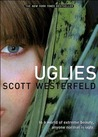

{'Unnamed: 0': 169,
 'authors': "['Scott Westerfeld']",
 'authors_2': "['Scott Westerfeld']",
 'average_rating': 3.86,
 'best_book_id': 24770,
 'book_id': 187,
 'books_count': 98,
 'description': "Tally is about to turn sixteen, and she can't wait. In just a "
                "few weeks she'll have the operation that will turn her from a "
                'repellent ugly into a stunning pretty. And as a pretty, '
                "she'll be catapulted into a high-tech paradise where her only "
                "job is to have fun.But Tally's new friend Shay isn't sure she "
                'wants to become a pretty. When Shay runs away, Tally learns '
                "about a whole new side of the pretty world—and it isn't very "
                'pretty. The authorities offer Tally a choice: find her friend '
                "and turn her in, or never turn pretty at all. Tally's choice "
                'will change her world forever....',
 'genres': "['young-adult', 'science-fiction', '

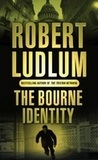

{'Unnamed: 0': 200,
 'authors': "['Robert Ludlum']",
 'authors_2': "['Robert Ludlum']",
 'average_rating': 3.98,
 'best_book_id': 7869,
 'book_id': 222,
 'books_count': 143,
 'description': 'Alternate cover for this ISBN can be found hereWho is Jason '
                'Bourne? Is he an assassin, a terrorist, a thief? Why has he '
                'got four million dollars in a Swiss bank account? Why has '
                'someone tried to murder him?...Jason Bourne does not know the '
                'answer to any of these questions. Suffering from amnesia, he '
                'does not even know that he is Jason Bourne. What manner of '
                'man is he? What are his secrets? Who has he killed?',
 'genres': "['fiction', 'thriller', 'mystery', 'suspense', 'crime']",
 'goodreads_book_id': 7869,
 'image_url': 'https://images.gr-assets.com/books/1335860740m/7869.jpg',
 'index': 200,
 'isbn': '752864327',
 'isbn13': 9780752864330.0,
 'language_code': 'eng',
 'original_publicati

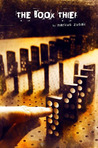

{'Unnamed: 0': 41,
 'authors': "['Markus Zusak']",
 'authors_2': "['Markus Zusak']",
 'average_rating': 4.36,
 'best_book_id': 19063,
 'book_id': 47,
 'books_count': 251,
 'description': "Librarian's note: An alternate cover edition can be found "
                'hereIt is 1939. Nazi Germany. The country is holding its '
                'breath. Death has never been busier, and will be busier '
                "still.By her brother's graveside, Liesel's life is changed "
                'when she picks up a single object, partially hidden in the '
                "snow. It is The Gravedigger's Handbook, left behind there by "
                'accident, and it is her first act of book thievery. So begins '
                'a love affair with books and words, as Liesel, with the help '
                'of her accordian-playing foster father, learns to read. Soon '
                "she is stealing books from Nazi book-burnings, the mayor's "
                "wife's library, wherever ther

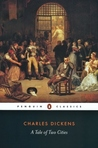

{'Unnamed: 0': 75,
 'authors': "['Charles Dickens', 'Richard Maxwell', 'Hablot Knight Browne']",
 'authors_2': "['Charles Dickens', 'Richard Maxwell', 'Hablot Knight Browne']",
 'average_rating': 3.81,
 'best_book_id': 1953,
 'book_id': 83,
 'books_count': 525,
 'description': 'After eighteen years as a political prisoner in the Bastille, '
                'the ageing Doctor Manette is finally released and reunited '
                'with his daughter in England. There the lives of two very '
                'different men, Charles Darnay, an exiled French aristocrat, '
                'and Sydney Carton, a disreputable but brilliant English '
                'lawyer, become enmeshed through their love for Lucie Manette. '
                'From the tranquil roads of London, they are drawn against '
                'their will to the vengeful, bloodstained streets of Paris at '
                'the height of the Reign of Terror, and they soon fall under '
                'the lethal sha

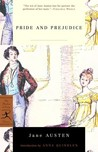

{'Unnamed: 0': 9,
 'authors': "['Jane Austen']",
 'authors_2': "['Jane Austen']",
 'average_rating': 4.24,
 'best_book_id': 1885,
 'book_id': 10,
 'books_count': 3455,
 'description': 'Alternate cover edition of ISBN 9780679783268Since its '
                'immediate success in 1813, Pride and Prejudice has remained '
                'one of the most popular novels in the English language. Jane '
                'Austen called this brilliant work "her own darling child" and '
                'its vivacious heroine, Elizabeth Bennet, "as delightful a '
                'creature as ever appeared in print." The romantic clash '
                'between the opinionated Elizabeth and her proud beau, Mr. '
                'Darcy, is a splendid performance of civilized sparring. And '
                "Jane Austen's radiant wit sparkles as her characters dance a "
                'delicate quadrille of flirtation and intrigue, making this '
                'book the most superb comedy of mann

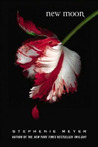

{'Unnamed: 0': 42,
 'authors': "['Stephenie Meyer']",
 'authors_2': "['Stephenie Meyer']",
 'average_rating': 3.52,
 'best_book_id': 49041,
 'book_id': 49,
 'books_count': 194,
 'description': 'There is an alternate cover edition for ISBN13 9780316160193 '
                'here. I knew we were both in mortal danger. Still, in that '
                'instant, I felt well. Whole. I could feel my heart racing in '
                'my chest, the blood pulsing hot and fast through my veins '
                'again. My lungs filled deep with the sweet scent that came '
                'off his skin. It was like there had never been any hole in my '
                'chest. I was perfect - not healed, but as if there had never '
                'been a wound in the first place. I FELT LIKE I WAS TRAPPED IN '
                'ONE OF THOSE TERRIFYING NIGHTMARES, the one where you have to '
                "run, run till your lungs burst, but you can't make your body "
                'move fast 

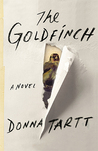

{'Unnamed: 0': 132,
 'authors': "['Donna Tartt']",
 'authors_2': "['Donna Tartt']",
 'average_rating': 3.87,
 'best_book_id': 17333223,
 'book_id': 146,
 'books_count': 108,
 'description': 'It begins with a boy. Theo Decker, a thirteen-year-old New '
                'Yorker, miraculously survives an accident that kills his '
                'mother. Abandoned by his father, Theo is taken in by the '
                'family of a wealthy friend. Bewildered by his strange new '
                "home on Park Avenue, disturbed by schoolmates who don't know "
                'how to talk to him, and tormented above all by his unbearable '
                'longing for his mother, he clings to one thing that reminds '
                'him of her: a small, mysteriously captivating painting that '
                'ultimately draws Theo into the underworld of art.As an adult, '
                'Theo moves silkily between the drawing rooms of the rich and '
                'the dusty labyrinth of

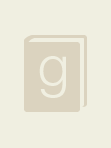

{'Unnamed: 0': 419,
 'authors': "['Emily Giffin']",
 'authors_2': "['Emily Giffin']",
 'average_rating': 3.92,
 'best_book_id': 42155,
 'book_id': 455,
 'books_count': 43,
 'description': 'Following the smash-hit Something Borrowed comes story of '
                'betrayal, redemption, and forgiveness\xa0Darcy Rhone has '
                'always been able to rely on a few things: Her beauty and '
                'charm.\xa0Her fiance, Dex. Her lifelong best friend, '
                'Rachel.\xa0She never needed anything else.\xa0Or so she '
                'thinks until Dex calls off their dream wedding and she '
                'uncovers the ultimate betrayal. Blaming everyone but herself, '
                'Darcy flees to London and attempts to re-create her glamorous '
                'life on a new continent. But to her dismay, she discovers '
                'that her tried-and-true tricks no longer apply—and that her '
                'luck has finally expired. It is only then t

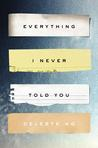

{'Unnamed: 0': 621,
 'authors': "['Celeste Ng']",
 'authors_2': "['Celeste Ng']",
 'average_rating': 3.78,
 'best_book_id': 18693763,
 'book_id': 668,
 'books_count': 62,
 'description': 'Lydia is dead. But they don’t know this yet.So begins this '
                'exquisite novel about a Chinese American family living in '
                '1970s small-town Ohio. Lydia is the favorite child of Marilyn '
                'and James Lee, and her parents are determined that she will '
                'fulfill the dreams they were unable to pursue. But when '
                'Lydia’s body is found in the local lake, the delicate '
                'balancing act that has been keeping the Lee family together '
                'is destroyed, tumbling them into chaos. A profoundly moving '
                'story of family, secrets, and longing, Everything I Never '
                'Told You is both a gripping page-turner and a sensitive '
                'family portrait, uncovering the ways in

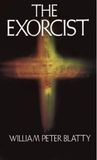

{'Unnamed: 0': 682,
 'authors': "['William Peter Blatty']",
 'authors_2': "['William Peter Blatty']",
 'average_rating': 4.14,
 'best_book_id': 179780,
 'book_id': 731,
 'books_count': 1,
 'description': 'Four decades after it first terrified the world, William '
                'Peter Blatty’s The Exorcist is back! An extraordinary classic '
                'work of horror and dark paranormal suspense. In this stunning '
                '40th Anniversary Edition, a desperate mother and two priests '
                'fight to free the soul of a little girl from a supernatural '
                'entity of pure malevolence.',
 'genres': "['horror', 'fiction', 'classics', 'paranormal', 'thriller', "
           "'fantasy', 'religion']",
 'goodreads_book_id': 179780,
 'image_url': 'https://images.gr-assets.com/books/1375168676m/179780.jpg',
 'index': 682,
 'isbn': '61007226',
 'isbn13': 9780061007220.0,
 'language_code': 'eng',
 'original_publication_year': 1971.0,
 'original_title': 'The E

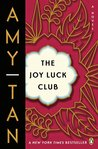

{'Unnamed: 0': 106,
 'authors': "['Amy Tan']",
 'authors_2': "['Amy Tan']",
 'average_rating': 3.9,
 'best_book_id': 7763,
 'book_id': 118,
 'books_count': 126,
 'description': 'Four mothers, four daughters, four families, whose histories '
                "shift with the four winds depending on who's telling the "
                'stories. In 1949, four Chinese women, recent immigrants to '
                'San Francisco, meet weekly to play mahjong and tell stories '
                'of what they left behind in China. United in loss and new '
                "hope for their daughters' futures, they call themselves the "
                'Joy Luck Club. Their daughters, who have never heard these '
                "stories, think their mothers' advice is irrelevant to their "
                'modern American lives – until their own inner crises reveal '
                "how much they've unknowingly inherited of their mothers' "
                'pasts. With wit and sensitivity, Amy Tan 

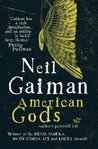

{'Unnamed: 0': 151,
 'authors': "['Neil Gaiman']",
 'authors_2': "['Neil Gaiman']",
 'average_rating': 4.11,
 'best_book_id': 30165203,
 'book_id': 167,
 'books_count': 196,
 'description': "Days before his release from prison, Shadow's wife, Laura, "
                'dies in a mysterious car crash. Numbly, he makes his way back '
                'home. On the plane, he encounters the enigmatic Mr Wednesday, '
                'who claims to be a refugee from a distant war, a former god '
                'and the king of America. Together they embark on a profoundly '
                'strange journey across the heart of the USA, whilst all '
                'around them a storm of preternatural and epic proportions '
                'threatens to break.Scary, gripping and deeply unsettling, '
                'American Gods takes a long, hard look into the soul of '
                "America. You'll be surprised by what - and who - it finds "
                "there...This is the author's 

[None, None, None, None, None]

In [66]:
[vis_recs(books_all_df, sample_id, sim_df, rec_df, 4) for sample_id in sample_ids]